# Stock Analysis project
## Data gathering
The data was gathered from the Bovespa website in the historical quotes [link](http://www.bmfbovespa.com.br/pt_br/servicos/market-data/historico/mercado-a-vista/cotacoes-historicas/). The instructions to interpret the data are in the same website.

In [1]:
%matplotlib inline

# All imports
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

# Constants
RANDOM_SEED = 42

# Data gathering for ITSA4
paths = ['stock_price\\inputs\\COTAHIST_A2006.TXT','stock_price\\inputs\\COTAHIST_A2007.TXT',
        'stock_price\\inputs\\COTAHIST_A2008.TXT','stock_price\\inputs\\COTAHIST_A2009.TXT',
        'stock_price\\inputs\\COTAHIST_A2010.TXT','stock_price\\inputs\\COTAHIST_A2011.TXT',
        'stock_price\\inputs\\COTAHIST_A2012.TXT','stock_price\\inputs\\COTAHIST_A2013.TXT',
        'stock_price\\inputs\\COTAHIST_A2014.TXT','stock_price\\inputs\\COTAHIST_A2015.TXT']
df = pd.DataFrame()
for path in paths:
    file = open(path,'r')
    for line in file:
        if (line[12:18] == 'ITSA4 '):
            df = df.append({'year': int(line[2:6]),'month': int(line[6:8]),'day': int(line[8:10]),
                            'open': int(line[56:69])/100.,'high': int(line[69:82])/100.,
                            'low': int(line[82:95])/100.,'close': int(line[108:121])/100.,
                            'volume': int(line[152:170])},ignore_index=True)
    file.close
df.describe()

,close,day,high,low,month,open,volume,year
count,2470.000000,2470.000000,2470.000000,2470.000000,2470.000000,2470.000000,2.470000e+03,2470.000000
mean,10.052960,15.768421,10.186356,9.895947,6.501619,10.051919,9.869202e+06,2010.503644
std,1.558419,8.754459,1.557275,1.551361,3.413070,1.558657,6.455192e+06,2.870181
min,5.040000,1.000000,5.240000,4.820000,1.000000,5.000000,8.920000e+05,2006.000000
25%,8.890000,8.000000,9.020000,8.760000,4.000000,8.902500,5.397350e+06,2008.000000
50%,9.840000,16.000000,9.980000,9.690000,7.000000,9.830000,8.430600e+06,2011.000000
75%,11.327500,23.000000,11.495000,11.147500,9.000000,11.347500,1.256762e+07,2013.000000
max,13.990000,31.000000,14.060000,13.830000,12.000000,14.050000,7.177790e+07,2015.000000


## Technical analysis
The main data has already been gathered. Now it is time to use what is called technical analysis to improve the data we already have.

The technical analysis consideres that the price movement of a stock reflects every thing that you need to know about the stock. The following image shows the analysis of a technical analist:

![Analysis of a technical analist](http://www.liberatedstocktrader.com/wp-content/uploads/stock-market-analysis-sept-20-2010.jpg)

To perform this analysis there is some indicators (calculated from the prizes) that are used for the behaviour prediction. We will use [Moving Averages](http://www.investopedia.com/terms/m/movingaverage.asp) for 5, 8, 21 and 50 periods.

It is important to notice that we will only have the data for previous periods and not from our period. So to start we will make every date know about its 50 previous closing prices

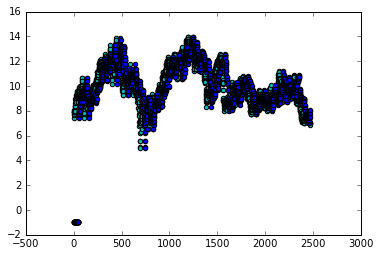

In [2]:
# Knowing the past
for i in range(1,50 + 1):
    df['close'+str(i)] = -1
    for j in range(50,len(df)):
        df.loc[j,'close'+str(i)] = df.loc[j-i,'close']
for i in range(1,50 + 1):
    df['low'+str(i)] = -1
    for j in range(50,len(df)):
        df.loc[j,'low'+str(i)] = df.loc[j-i,'low']
for i in range(1,50 + 1):
    df['high'+str(i)] = -1
    for j in range(50,len(df)):
        df.loc[j,'high'+str(i)] = df.loc[j-i,'high']
for i in range(1,50 + 1):
    df['open'+str(i)] = -1
    for j in range(50,len(df)):
        df.loc[j,'open'+str(i)] = df.loc[j-i,'open']

# Verify if the code worked
plt.scatter(df.index.tolist(),df['close'].values,c='c')
plt.scatter(df.index.tolist(),df['close50'].values)

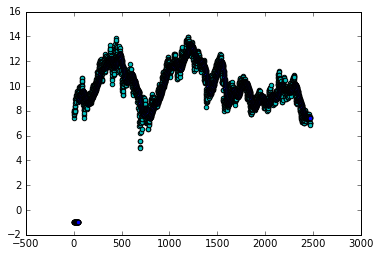

In [3]:
# Create the moving averages
for i in (5,8,21,50):
    df['MA'+str(i)] = -1
    for j in range(50,len(df)):
        sum = 0
        for k in range(1,i+1):
            sum += df.loc[j,'close'+str(k)]
        df.loc[j,'MA'+str(i)] = sum/i

# Verify if the code worked
plt.scatter(df.index.tolist(),df['close'].values,c='c')
plt.scatter(df.index.tolist(),df['MA50'].values)

We also want to know which day of the week it is. There is some studies that argue that a stock has a higher probability of moving up depending of the day of the week.

In [4]:
df['week_day']=-1
for i in range(len(df)):
    df.loc[i,'week_day'] = datetime.datetime(int(df.loc[i,'year']), int(df.loc[i,'month']), int(df.loc[i,'day'])).weekday()
# Just for information Monday to Sunday is 0 to 6

The volume that we have are also from the last days. In the case of the volume we will gather only the volume for the last 5 days.

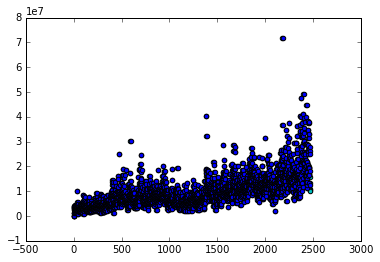

In [5]:
for i in range(1,5 + 1):
    df['volume'+str(i)] = -1
    for j in range(5,len(df)):
        df.loc[j,'volume'+str(i)] = df.loc[j-i,'volume']

# Verify if the code worked
plt.scatter(df.index.tolist(),df['volume'].values,c='c')
plt.scatter(df.index.tolist(),df['volume5'].values)

## Preparing the data to use
Since the price of the stock varies alot, the important aspect here is the movement relative to the last price. So every price show be divided by the last price (close1) so we have the relative price of the movements until here.
We will do the same for the volumes (volume1).

In [6]:
df.loc[:,'close'] = df.loc[:,'close']/df.loc[:,'close1']
df.loc[:,'low'] = df.loc[:,'low']/df.loc[:,'close1']
df.loc[:,'high'] = df.loc[:,'high']/df.loc[:,'close1']
df.loc[:,'open'] = df.loc[:,'open']/df.loc[:,'close1']

for i in range(2,50+1):
    df.loc[:,'close'+str(i)] = df.loc[:,'close'+str(i)]/df.loc[:,'close1']
    df.loc[:,'low'+str(i)] = df.loc[:,'low'+str(i)]/df.loc[:,'close1']
    df.loc[:,'high'+str(i)] = df.loc[:,'high'+str(i)]/df.loc[:,'close1']
    df.loc[:,'open'+str(i)] = df.loc[:,'open'+str(i)]/df.loc[:,'close1']
    
for i in (5,8,21,50):
    df.loc[:, 'MA'+str(i)] = df.loc[:, 'MA'+str(i)]/df.loc[:,'close1']

df.loc[:,'open1'] = df.loc[:,'open1']/df.loc[:,'close1']
df.loc[:,'high1'] = df.loc[:,'high1']/df.loc[:,'close1']
df.loc[:,'low1'] = df.loc[:,'low1']/df.loc[:,'close1']
df.loc[:,'close1'] = df.loc[:,'close1']/df.loc[:,'close1']

We will do the same for the volumes (volume1).

In [7]:
df.loc[:,'volume'] = df.loc[:,'volume']/df.loc[:,'volume1']

for i in range(2,5+1):
    df.loc[:,'volume'+str(i)] = df.loc[:,'volume'+str(i)]/df.loc[:,'volume1']
    
df.loc[:,'volume1'] = df.loc[:,'volume1']/df.loc[:,'volume1']

## Clean the data
Since the data is now read, we need to erase the 50 first days. They do not have all the indicators that we need for the analysis and it can bring some problems.

In [8]:
df = df.loc[50:].reset_index()

df.describe()

,index,close,day,high,low,month,open,volume,year,close1,...,MA5,MA8,MA21,MA50,week_day,volume1,volume2,volume3,volume4,volume5
count,2420.000000,2420.000000,2420.000000,2420.000000,2420.000000,2420.000000,2420.000000,2420.000000,2420.000000,2420.0,...,2420.000000,2420.000000,2420.000000,2420.000000,2420.000000,2420.0,2420.000000,2420.000000,2420.000000,2420.000000
mean,1259.500000,1.000148,15.827686,1.013691,0.984216,6.598760,0.999922,1.091569,2010.596694,1.0,...,1.000783,1.001311,1.003105,1.006347,1.995868,1.0,1.090639,1.112967,1.124177,1.126649
std,698.738148,0.023617,8.758794,0.018685,0.018869,3.378029,0.013028,0.484045,2.824945,0.0,...,0.025925,0.034205,0.052738,0.077034,1.409816,0.0,0.489919,0.566877,0.600116,0.609671
min,50.000000,0.884451,1.000000,0.915966,0.804598,1.000000,0.897292,0.148279,2006.000000,1.0,...,0.830043,0.758409,0.800945,0.844419,0.000000,1.0,0.155512,0.214063,0.107376,0.177112
25%,654.750000,0.987614,8.000000,1.003876,0.976634,4.000000,0.994764,0.759577,2008.000000,1.0,...,0.985563,0.980498,0.969461,0.951452,1.000000,1.0,0.757911,0.734696,0.725392,0.726525
50%,1259.500000,1.000000,16.000000,1.010712,0.986952,7.000000,1.000000,0.996591,2011.000000,1.0,...,1.000254,0.999838,0.996713,0.997288,2.000000,1.0,1.003922,0.990703,0.998705,0.988535
75%,1864.250000,1.011497,23.000000,1.020516,0.995135,9.000000,1.005638,1.321244,2013.000000,1.0,...,1.014594,1.019410,1.031469,1.044716,3.000000,1.0,1.316523,1.344790,1.357989,1.382446
max,2469.000000,1.251471,31.000000,1.251471,1.070833,12.000000,1.131944,6.430380,2015.000000,1.0,...,1.216830,1.295988,1.512068,1.692698,4.000000,1.0,6.744062,6.564526,9.389013,6.948186


## Preparing the target
Until now we have not prepared the target, the target will be a data frame that gives 1 when price close higher than price open, otherwise it returns 1.

(array([ 1245.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  1175.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

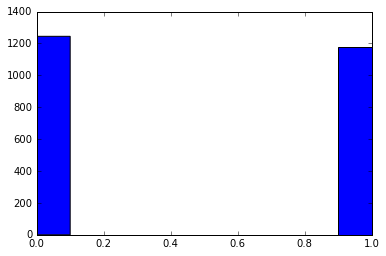

In [9]:
y_all = []

for i in range(len(df)):
    is_higher = (1 if (df.loc[i,'close']/df.loc[i,'open'] > 1.) else 0)
    y_all.extend([is_higher])
    
plt.hist(y_all)

We can see that it is almost a 50% chance for the day to close higher or not.

## Prepare data
Now that we have the target we can clean our data to start the work.

In [10]:
X_all = df.drop(['index','close','low','high','open','volume'],1)

X_all.describe()

,day,month,year,close1,close2,close3,close4,close5,close6,close7,...,MA5,MA8,MA21,MA50,week_day,volume1,volume2,volume3,volume4,volume5
count,2420.000000,2420.000000,2420.000000,2420.0,2420.000000,2420.000000,2420.000000,2420.000000,2420.000000,2420.000000,...,2420.000000,2420.000000,2420.000000,2420.000000,2420.000000,2420.0,2420.000000,2420.000000,2420.000000,2420.000000
mean,15.827686,6.598760,2010.596694,1.0,1.000400,1.000799,1.001191,1.001525,1.001878,1.002201,...,1.000783,1.001311,1.003105,1.006347,1.995868,1.0,1.090639,1.112967,1.124177,1.126649
std,8.758794,3.378029,2.824945,0.0,0.023444,0.033641,0.041435,0.047055,0.052056,0.056340,...,0.025925,0.034205,0.052738,0.077034,1.409816,0.0,0.489919,0.566877,0.600116,0.609671
min,1.000000,1.000000,2006.000000,1.0,0.799060,0.781609,0.721030,0.680437,0.612394,0.574686,...,0.830043,0.758409,0.800945,0.844419,0.000000,1.0,0.155512,0.214063,0.107376,0.177112
25%,8.000000,4.000000,2008.000000,1.0,0.988634,0.981553,0.977162,0.974541,0.970942,0.968135,...,0.985563,0.980498,0.969461,0.951452,1.000000,1.0,0.757911,0.734696,0.725392,0.726525
50%,16.000000,7.000000,2011.000000,1.0,1.000000,1.000000,1.000000,1.000938,1.001033,1.000854,...,1.000254,0.999838,0.996713,0.997288,2.000000,1.0,1.003922,0.990703,0.998705,0.988535
75%,23.000000,9.000000,2013.000000,1.0,1.012458,1.018640,1.023225,1.027251,1.029356,1.031764,...,1.014594,1.019410,1.031469,1.044716,3.000000,1.0,1.316523,1.344790,1.357989,1.382446
max,31.000000,12.000000,2015.000000,1.0,1.130645,1.251786,1.371820,1.403131,1.422619,1.416830,...,1.216830,1.295988,1.512068,1.692698,4.000000,1.0,6.744062,6.564526,9.389013,6.948186


# Split the data
Now that our data is good to go we will split the data to start to evaluate the problem. Since almost of 50% of the cases are good we will not worry about stratification, we will use the simple train_test_split.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_all,y_all, test_size = 0.25, random_state = RANDOM_SEED)

# Feature selection
We will use the PCA to evaluate the features and the sklearn.feature_selection.SelectKBest to evaluate the features considering the target values. The objective is to reduce it for a more reasonable number. In the moment we have 213 features. We will  reduce the number to components to 20.

In [12]:
pca = PCA()
pca.fit(X_train,y_train)
#print pca.explained_variance_ratio_

#ica = FastICA(max_iter=20000, tol=0.1, random_state = RANDOM_SEED)
#ica.fit(X_train,y_train)

skb = SelectKBest(f_classif,k=50)
skb.fit(pca.transform(X_train),y_train)
#print skb.scores_

X_train_reduced = skb.transform(pca.transform(X_train))
X_test_reduced = skb.transform(pca.transform(X_test))

Note: First I started with PCA and k=20 in SelectKBest, as mentioned, but the results were not good. Trying to improve I included FastICA and increased the number of variables in the SelectKBest. It improved the performance.

# Defining the classifier
Since we want to know if the stock will go up in a given day or not it is a classification problem. Considering the amount of data that we have, over 2000, we will use the Support Vector Classifier.

For the classifier decision we are using the recommendation of the sklearn website, see image below:

![sklearn map](http://scikit-learn.org/stable/_static/ml_map.png)

Together with the classifier we will implement the GridSearchCV and the makescorer.

In [13]:
svc = SVC(random_state = RANDOM_SEED)

parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':[1, 1.5, 3, 5, 10], 'degree':[2,3,4]}

precision_scorer = make_scorer(precision_score)

clf = GridSearchCV(svc, parameters, scoring = precision_scorer)

clf.fit(X_train_reduced, y_train)

print(clf.best_estimator_)
print(clf.best_score_)
svc = clf.best_estimator_

print("The score in the training data was %0.4f." % (precision_score(y_train,svc.predict(X_train_reduced))))
print("The score in the test data was %0.4f." % (precision_score(y_test,svc.predict(X_test_reduced))))


C:\Users\Ivan\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=2, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)
0.606085830559
The score in the training data was 0.6842.
The score in the test data was 0.5152.


Since SVC is not working lets go to KNeighborsClassifier, as the map suggests.

In [14]:
knc = KNeighborsClassifier()

parameters = {'n_neighbors':[2,4,5,8,16,32,64], 'p':[2, 3], 'leaf_size':[2,5,10,20,30]}

clf = GridSearchCV(knc, parameters, scoring = precision_scorer)

clf.fit(X_train_reduced, y_train)

print(clf.best_estimator_)
print(clf.best_score_)
knc = clf.best_estimator_

print("The score in the training data was %0.4f." % (precision_score(y_train,knc.predict(X_train_reduced))))
print("The score in the test data was %0.4f." % (precision_score(y_test,knc.predict(X_test_reduced))))

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=64, p=2,
           weights='uniform')
0.504139984271
The score in the training data was 0.5302.
The score in the test data was 0.4879.


KNeighborsClassifier also did not work well. Let's try 2 ensemble methods, AdaBoostClassifier and RandomForestClassifier.

In [ ]:
abc = AdaBoostClassifier(random_state = RANDOM_SEED)

parameters = {'algorithm':('SAMME','SAMME.R'), 'n_estimators':[10,30,50,80,120,300,500,800,1200], 'learning_rate':[0.1,0.5,1.0,1.5,2.0]}

clf = GridSearchCV(abc, parameters, scoring = precision_scorer)

clf.fit(X_train_reduced, y_train)

print(clf.best_estimator_)
print(clf.best_score_)
abc = clf.best_estimator_

print("The score in the training data was %0.4f." % (precision_score(y_train,abc.predict(X_train_reduced))))
print("The score in the test data was %0.4f." % (precision_score(y_test,abc.predict(X_test_reduced))))

In [ ]:
rfc = RandomForestClassifier(n_jobs = -1, random_state = RANDOM_SEED)

parameters = {'n_estimators':[10,30,50,80,120,300,500,800,1200], 'max_depth':[5,8,15,25,30,None],
              'min_samples_split':[1,2,5,10,15,100], 'min_samples_leaf':[1,2,5,10], 'max_features':('sqrt','log2',None)}

clf = GridSearchCV(rfc, parameters, scoring = precision_scorer)

clf.fit(X_train_reduced, y_train)

print(clf.best_estimator_)
print(clf.best_score_)
rfc = clf.best_estimator_

print("The score in the training data was %0.4f." % (precision_score(y_train,rfc.predict(X_train_reduced))))
print("The score in the test data was %0.4f." % (precision_score(y_test,rfc.predict(X_test_reduced))))